# Self-Driving Car Engineer Nanodegree
## Project: **Finding Lane Lines on the Road** 


In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, draw_lines_fn=draw_lines):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_fn(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [3]:
# Pipeline to find lanes
def pipeline(image, cfg, draw_lines_fn):
    # Convert to greyscale    
    greyscale_image = grayscale(image)

    # Smoothen the image using Gaussian blur
    smoothed_image = gaussian_blur(greyscale_image, cfg["gaussian_blur"]["kernel_size"])

    # Find canny edges
    images_with_canny_edges = canny(smoothed_image, \
                                    cfg["canny"]["low_threshold"], \
                                    cfg["canny"]["high_threshold"])

    # Apply mask 
    imshape = image.shape
    Y = imshape[0]
    X = imshape[1]

    mask = {
        "LOWER_LEFT"  : (0,Y - 20),
        "UPPER_LEFT"  : (X/2.1, Y/1.6),
        "UPPER_RIGHT" : (X/1.8, Y/1.6),
        "LOWER_RIGHT" : (X, Y-20),
    }
    vertices = np.array([[ \
                         mask["LOWER_LEFT"], \
                         mask["UPPER_LEFT"], \
                         mask["UPPER_RIGHT"], \
                         mask["LOWER_RIGHT"] \
                         ]], dtype=np.int32)
    cropped_image = region_of_interest(images_with_canny_edges, vertices)

    
    # Find edges
    image_with_edges = hough_lines(cropped_image, \
                                   cfg["hough_transform"]["rho"], \
                                   cfg["hough_transform"]["theta"], \
                                   cfg["hough_transform"]["threshold"], \
                                   cfg["hough_transform"]["min_line_length"], \
                                   cfg["hough_transform"]["max_line_gap"],
                                   draw_lines_fn)
    
    
    # Overlay lanes on the image
    images_with_lanes = weighted_img(image_with_edges, \
                                     image, \
                                     cfg["overlay"]["α"], \
                                     cfg["overlay"]["β"], \
                                     cfg["overlay"]["γ"])

    return images_with_lanes


CONFIG = {
    "gaussian_blur": {
      "kernel_size": 5,  
    },
    "canny" : {
        "low_threshold" : 100,
        "high_threshold": 200
    },
    "hough_transform" : {
        # distance resolution in pixels of the Hough grid
        "rho": 1, 
        # angular resolution in radians of the Hough grid
        "theta": np.pi/180, 
        # minimum number of votes (intersections in Hough grid cell)
        "threshold": 1,     
        #minimum number of pixels making up a line
        "min_line_length": 10, 
        # maximum gap in pixels between connectable line segments
        "max_line_gap": 1    
    },
    "overlay" : {
        "α": 0.8, 
        "β": 1., 
        "γ": 0.
    }  
}



In [4]:
# Helper functions to run experiments on images
import os
from IPython.display import Image, display

def run_test_on_images(test_name, draw_lines_fn):
    TEST_DIR = "test_images/"
    TEST_OUTPUT_DIR = os.path.join("test_images_output/", test_name)

    if not os.path.exists(TEST_OUTPUT_DIR):
        os.mkdir(TEST_OUTPUT_DIR)


    image_files = os.listdir(TEST_DIR)

    for image_file in image_files:
        # Read in the image
        image_path = os.path.join(TEST_DIR, image_file)
        output = os.path.join(TEST_OUTPUT_DIR, image_file)
        print(image_path)
        image = mpimg.imread(image_path)
        mpimg.imsave(output, pipeline(image, CONFIG, draw_lines_fn))

        
def display_images(test_name):
    TEST_DIR = "test_images/"
    TEST_OUTPUT_DIR = os.path.join("test_images_output/", test_name)
    image_files = os.listdir(TEST_DIR)

    for image_file in image_files:
        image_path = os.path.join(TEST_OUTPUT_DIR, image_file)
        print(image_path)
        display(Image(filename=image_path, width=400, height=300))

In [5]:
# Helper functions to run experiments on videos

from moviepy.editor import VideoFileClip
from IPython.display import HTML

def run_test_on_videos(test_name, draw_lines_fn, duration=-1):
    TEST_DIR = "test_videos/"
    TEST_OUTPUT_DIR = os.path.join("test_videos_output/", test_name)

    if not os.path.exists(TEST_OUTPUT_DIR):
        os.mkdir(TEST_OUTPUT_DIR)
        
    video_files = os.listdir(TEST_DIR)

    for video_file in video_files:
        video = os.path.join(TEST_DIR, video_file)
        output = os.path.join(TEST_OUTPUT_DIR, video_file)       

        print(video_file)
        
        clip1 = VideoFileClip(video)
        if not duration == -1:
            clip1 = VideoFileClip(video).subclip(0, duration)

        def process(image):
            result = pipeline(image, CONFIG, draw_lines_fn)
            return result
        
        white_clip = clip1.fl_image(process) 
        %time white_clip.write_videofile(output, audio=False)

        
from IPython.display import Video, display
def display_videos(test_name):
    TEST_DIR = "test_videos/"
    TEST_OUTPUT_DIR = os.path.join("test_videos_output/", test_name)
    files = os.listdir(TEST_DIR)

    for file in files:
        video_path = os.path.join(TEST_OUTPUT_DIR, file)
        print(video_path)
        display(Video(video_path))

## Experiment 1: Run pipeline on images and videos with the default draw lines function

In [6]:
run_test_on_images("default", draw_lines)

test_images/solidYellowCurve2.jpg
test_images/solidWhiteCurve.jpg
test_images/whiteCarLaneSwitch.jpg
test_images/solidWhiteRight.jpg
test_images/solidYellowCurve.jpg
test_images/solidYellowLeft.jpg


In [7]:
run_test_on_videos("default", draw_lines)

challenge.mp4
[MoviePy] >>>> Building video test_videos_output/default/challenge.mp4
[MoviePy] Writing video test_videos_output/default/challenge.mp4


100%|██████████| 251/251 [00:07<00:00, 35.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/default/challenge.mp4 

CPU times: user 11 s, sys: 328 ms, total: 11.3 s
Wall time: 7.91 s
solidWhiteRight.mp4
[MoviePy] >>>> Building video test_videos_output/default/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/default/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 66.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/default/solidWhiteRight.mp4 

CPU times: user 7.7 s, sys: 180 ms, total: 7.88 s
Wall time: 3.79 s
solidYellowLeft.mp4
[MoviePy] >>>> Building video test_videos_output/default/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/default/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:10<00:00, 62.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/default/solidYellowLeft.mp4 

CPU times: user 23.9 s, sys: 580 ms, total: 24.5 s
Wall time: 11.3 s


test_images_output/default/solidYellowCurve2.jpg


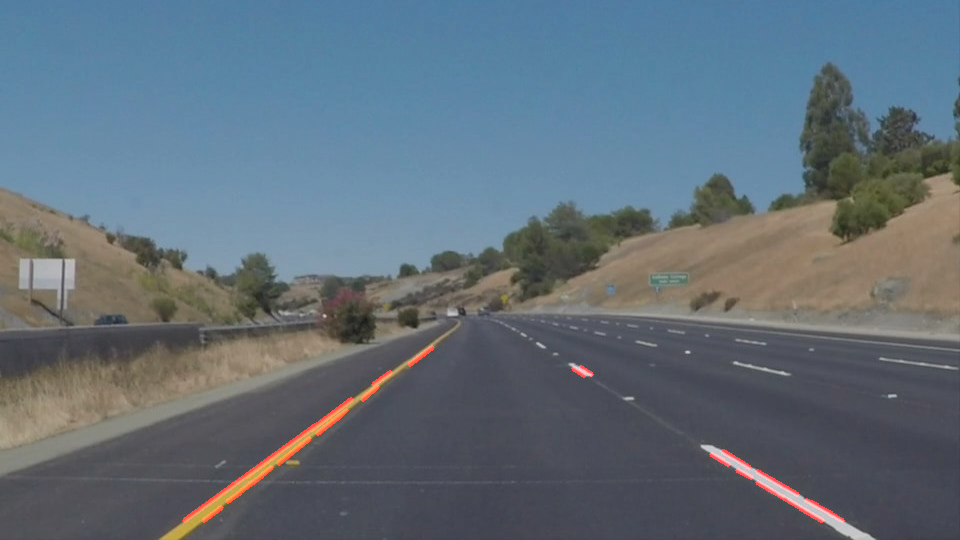

test_images_output/default/solidWhiteCurve.jpg


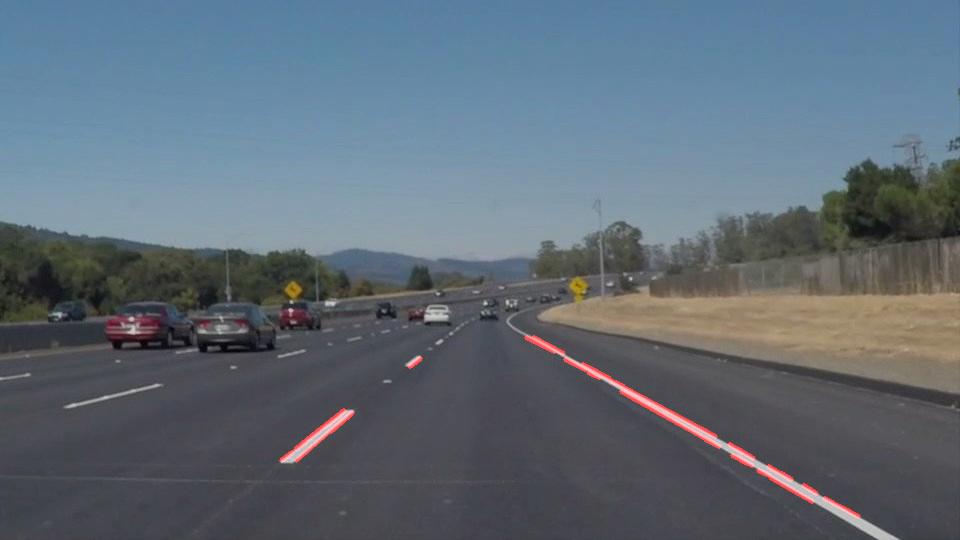

test_images_output/default/whiteCarLaneSwitch.jpg


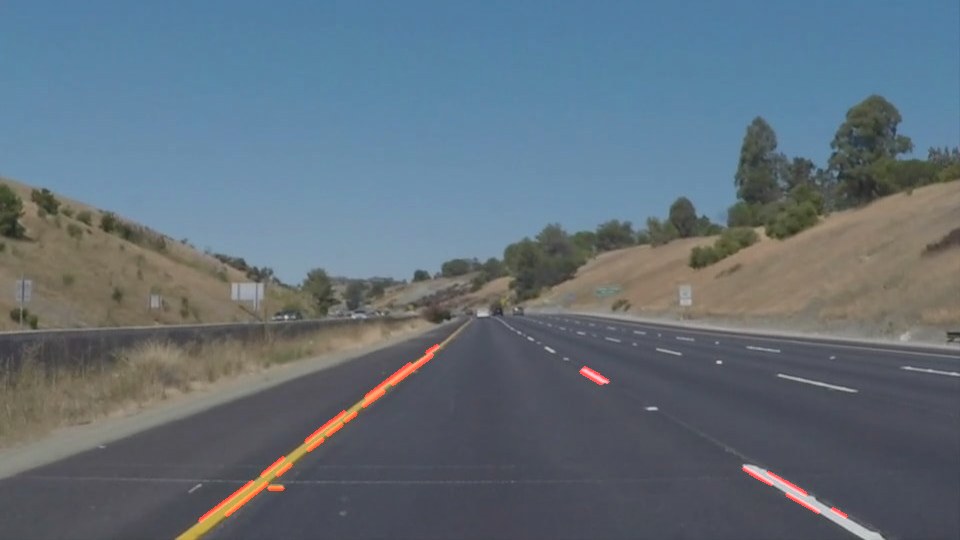

test_images_output/default/solidWhiteRight.jpg


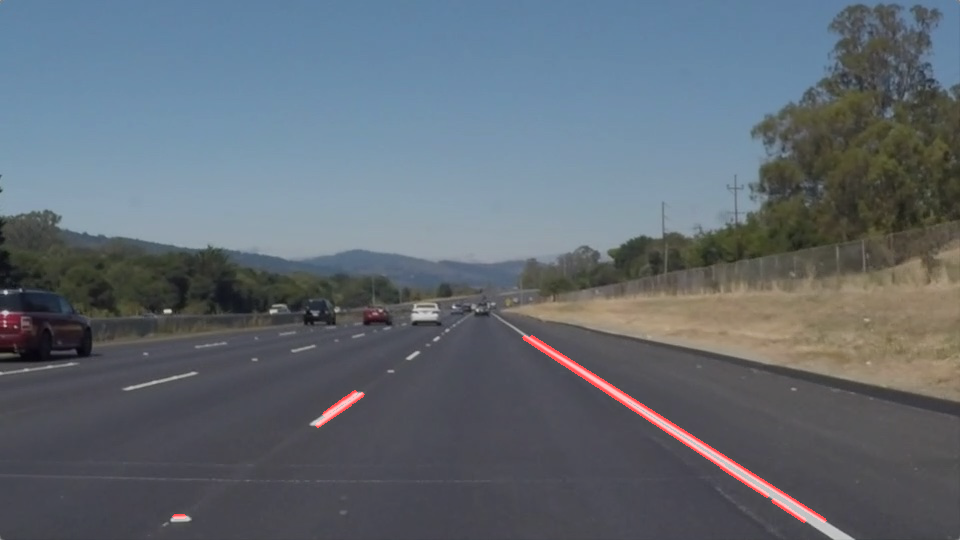

test_images_output/default/solidYellowCurve.jpg


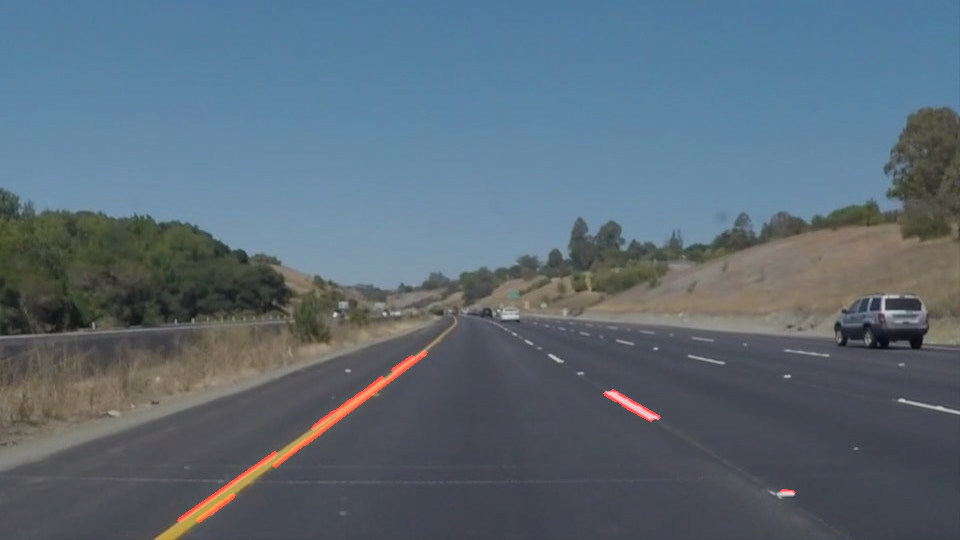

test_images_output/default/solidYellowLeft.jpg


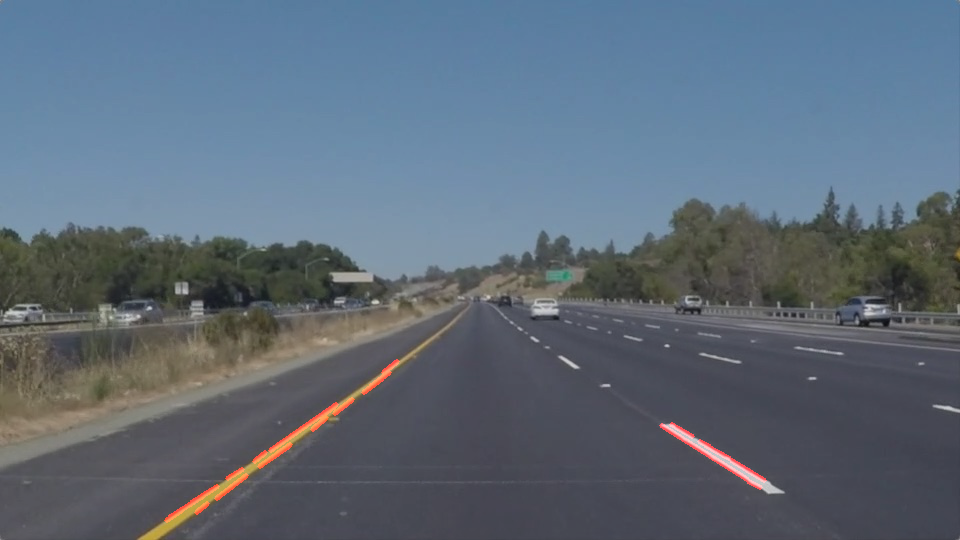

In [8]:
display_images("default")

In [9]:
display_videos("default")

test_videos_output/default/challenge.mp4


test_videos_output/default/solidWhiteRight.mp4


test_videos_output/default/solidYellowLeft.mp4


## Experiment 2: Run pipeline on images and videos with the draw lines function with average slope to interpolate lines

In [10]:
from collections import defaultdict
from pprint import pprint    

"""
This function extrapolates the lines found by the Hough tranform. The algorithm is 

for each line:
    - Calculate slope of the line
    - If slope > 0, then classify the line as left lane
        else classify the line as right lane
    - Calculate average slope and intercept for left and right lanes
    - Draw lines with the calculated left and right slopes that connects Y=image.height and Y=image.height/1.5
"""

def draw_lines_average_slope(img, lines, color=[255, 0, 0], thickness=10):
    lines_by_slope = {"L":[], "R":[]}
    slope_intercept = {"L":[], "R":[]}
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope=(y2-y1)/(x2-x1)
            if math.isnan(slope) or math.isinf(slope) or slope == 0.:
                continue
            intercept = y1 - (slope * x1)
            if slope > 0:
                lines_by_slope["L"].append(line)
                slope_intercept["L"].append([slope, intercept])
                
            else:
                lines_by_slope["R"].append(line)
                slope_intercept["R"].append([slope, intercept])
    try:
        
        imshape = img.shape
        Y = imshape[0]
        X = imshape[1]
        #     pprint(lines_by_slope)

        # Left line
        if len(slope_intercept["L"]) > 0 :
            slope, intercept = np.average(np.array(slope_intercept["L"]), axis=0)
            y1 = int(Y / 1.5 )
            x1 = int((y1 - intercept)/slope)

            #         print(x1, y1)
            y2 = Y 
            x2 = int((y2 - intercept)/slope)
            #         print(x2, y2)

            cv2.line(img, (x1, y1), (x2, y2), [255,0,0], thickness)
    
        # Right line
        if len(slope_intercept["R"]) > 0 :
            slope, intercept = np.average(np.array(slope_intercept["R"]), axis=0)
            #         print(slope, intercept)
            y1 = int(Y / 1.5 )
            x1 = int((y1 - intercept)/slope)

            y2 = Y 
            x2 = int((y2 - intercept)/slope)
            #         print(x2, y2)

            cv2.line(img, (x1, y1), (x2, y2), [255,0,0], thickness)

    except Exception as e:
        print("ERR:", e)
        import traceback
        traceback.print_exc()



In [11]:
run_test_on_images("average_slope", draw_lines_average_slope)

test_images/solidYellowCurve2.jpg
test_images/solidWhiteCurve.jpg
test_images/whiteCarLaneSwitch.jpg
test_images/solidWhiteRight.jpg
test_images/solidYellowCurve.jpg
test_images/solidYellowLeft.jpg


In [12]:
run_test_on_videos("average_slope", draw_lines_average_slope)

challenge.mp4
[MoviePy] >>>> Building video test_videos_output/average_slope/challenge.mp4
[MoviePy] Writing video test_videos_output/average_slope/challenge.mp4


100%|██████████| 251/251 [00:07<00:00, 31.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/average_slope/challenge.mp4 

CPU times: user 11.3 s, sys: 456 ms, total: 11.7 s
Wall time: 8.25 s
solidWhiteRight.mp4
[MoviePy] >>>> Building video test_videos_output/average_slope/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/average_slope/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:05<00:00, 34.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/average_slope/solidWhiteRight.mp4 

CPU times: user 12.5 s, sys: 264 ms, total: 12.7 s
Wall time: 6.26 s
solidYellowLeft.mp4
[MoviePy] >>>> Building video test_videos_output/average_slope/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/average_slope/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:21<00:00, 32.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/average_slope/solidYellowLeft.mp4 

CPU times: user 46.4 s, sys: 1.01 s, total: 47.5 s
Wall time: 21.9 s


test_images_output/average_slope/solidYellowCurve2.jpg


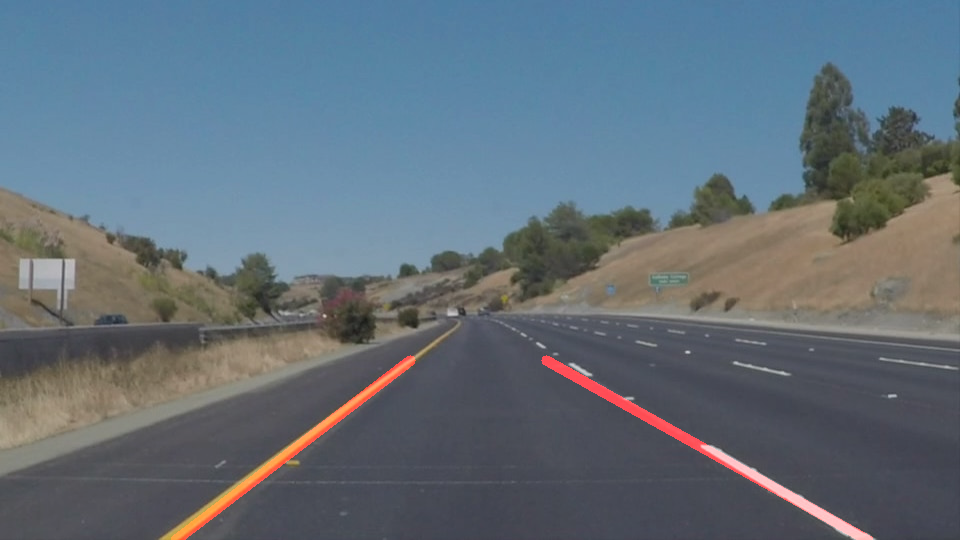

test_images_output/average_slope/solidWhiteCurve.jpg


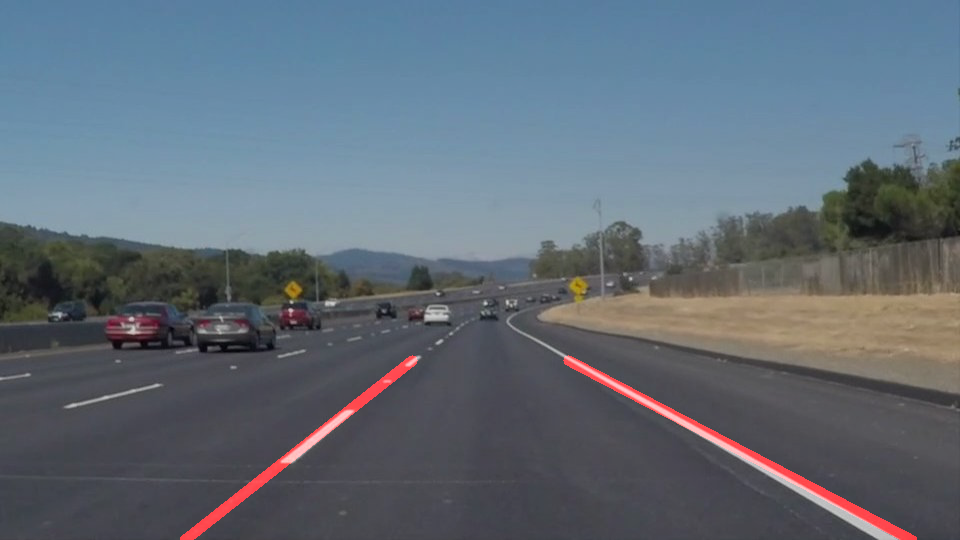

test_images_output/average_slope/whiteCarLaneSwitch.jpg


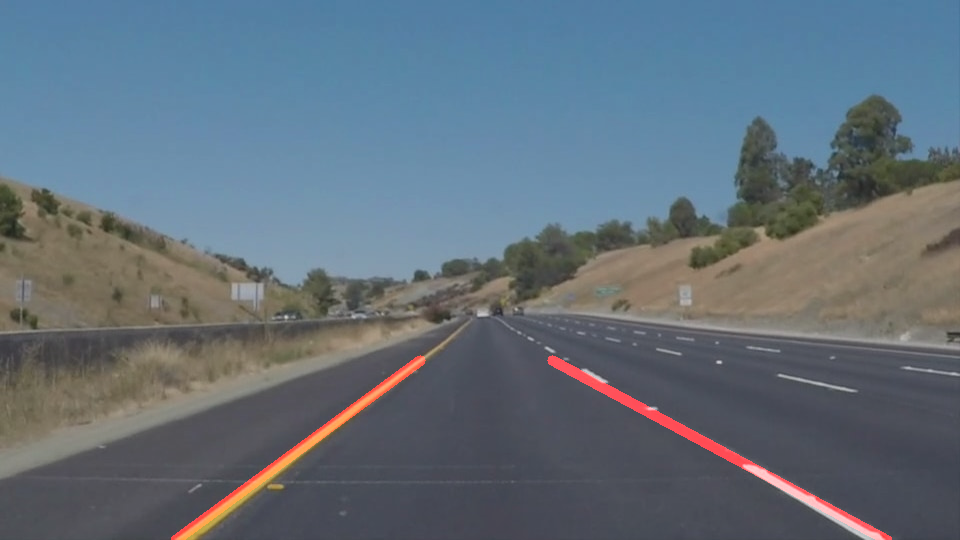

test_images_output/average_slope/solidWhiteRight.jpg


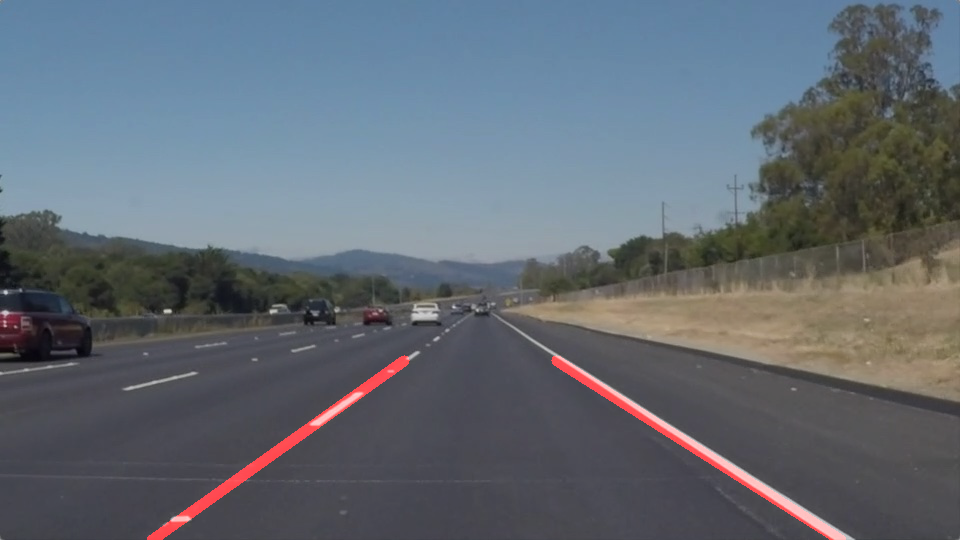

test_images_output/average_slope/solidYellowCurve.jpg


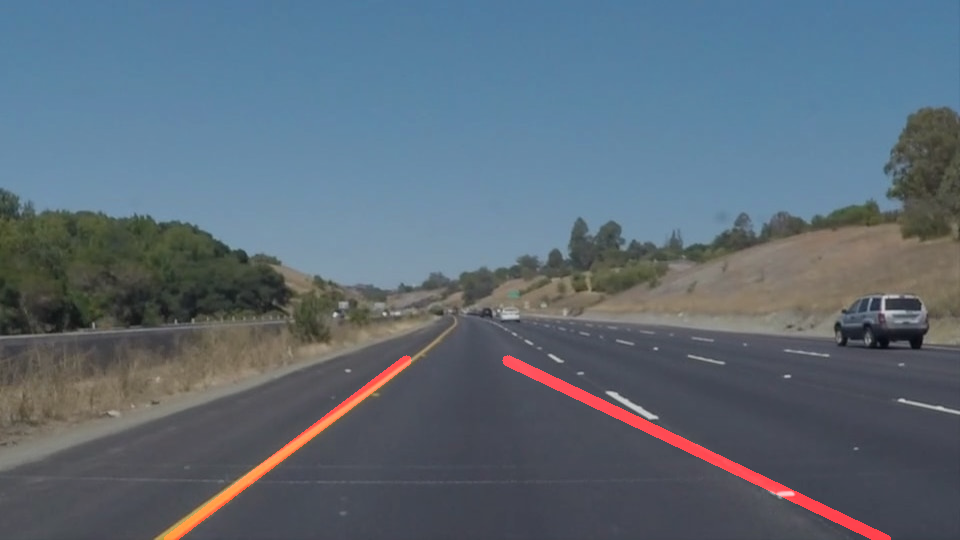

test_images_output/average_slope/solidYellowLeft.jpg


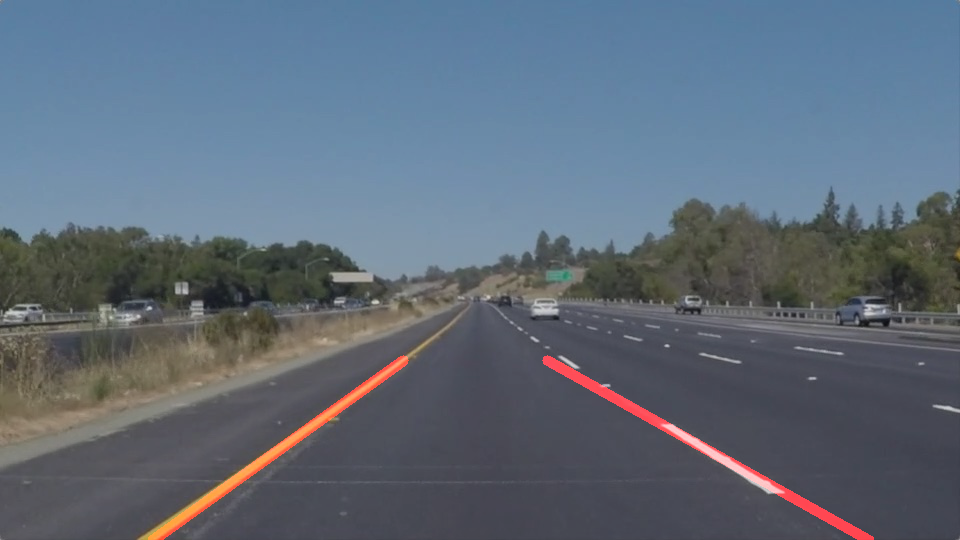

In [13]:
display_images("average_slope")

In [14]:
display_videos("average_slope")

test_videos_output/average_slope/challenge.mp4


test_videos_output/average_slope/solidWhiteRight.mp4


test_videos_output/average_slope/solidYellowLeft.mp4


## Experiment 3: Run pipeline on images and videos with the draw lines function where slope is calculated by fitting (least squares using L2 norm) the lines to left and right lanes

In [15]:
"""

This function extrapolates the lines found by the Hough tranform. The algorithm is 

for each line:
    - Calculate slope of the line
    - If slope > 0, then classify the line as left lane
        else classify the line as right lane
    - Calculate a line that passes through the points for left and right lanes using least squares (L2 norm)
    - Draw lines with the calculated left and right slopes that connects Y=image.height and Y=image.height/1.5

Reference : http://ottonello.gitlab.io/selfdriving/nanodegree/python/line%20detection/2016/12/18/extrapolating_lines.html
"""

def draw_lines_by_fit(img, lines, color=[255, 0, 0], thickness=10):
    
    points_by_slope = {"L":[], "R":[]}
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            slope=(y2-y1)/(x2-x1)
            if math.isnan(slope) or math.isinf(slope) or slope == 0.:
                continue

            if slope > 0:
                points_by_slope["L"].append((x1,y1))
                points_by_slope["L"].append((x2,y2))
            else:
                points_by_slope["R"].append((x1,y1))
                points_by_slope["R"].append((x2,y2))

    try:
        
        imshape = img.shape
        Y = imshape[0]
        X = imshape[1]
        if len(points_by_slope["L"]) > 0 :
            points = np.array(points_by_slope["L"])
            [vx,vy,x,y] = cv2.fitLine(points, cv2.DIST_L2,0,0.01,0.01)
            #         print(x,y,vx,vy)


            # Y = y - INTERPOLATION_DISTANCE_DOWN *vy
            # Y/1.5 = y + INTERPOLATION_DISTANCE_UP *vy

            INTERPOLATION_DISTANCE_DOWN = (y - Y)/vy
            INTERPOLATION_DISTANCE_UP = (Y/1.5 - y)/vy
            x1, y1 = x + INTERPOLATION_DISTANCE_UP * vx, y + INTERPOLATION_DISTANCE_UP *vy
            x2, y2 = x - INTERPOLATION_DISTANCE_DOWN * vx, y - INTERPOLATION_DISTANCE_DOWN *vy
            cv2.line(img, (x1, y1), (x2, y2), [255,0,0], thickness)
        
        if len(points_by_slope["R"]) > 0 :
            points = np.array(points_by_slope["R"])
            #         print(points)
            [vx,vy,x,y] = cv2.fitLine(points, cv2.DIST_L2,0,0.01,0.01)
            #         print(x,y,vx,vy)
            INTERPOLATION_DISTANCE_DOWN = (y - Y)/vy
            INTERPOLATION_DISTANCE_UP = (Y/1.5 - y)/vy
            x1, y1 = x + INTERPOLATION_DISTANCE_UP * vx, y + INTERPOLATION_DISTANCE_UP *vy
            x2, y2 = x - INTERPOLATION_DISTANCE_DOWN * vx, y - INTERPOLATION_DISTANCE_DOWN *vy
            cv2.line(img, (x1, y1), (x2, y2), [255,0,0], thickness)

    
    except Exception as e:
        print("ERR:", e)
        import traceback
        traceback.print_exc()

In [16]:
run_test_on_images("fit", draw_lines_by_fit)

test_images/solidYellowCurve2.jpg
test_images/solidWhiteCurve.jpg
test_images/whiteCarLaneSwitch.jpg
test_images/solidWhiteRight.jpg
test_images/solidYellowCurve.jpg
test_images/solidYellowLeft.jpg


In [17]:
run_test_on_videos("fit", draw_lines_by_fit)

challenge.mp4
[MoviePy] >>>> Building video test_videos_output/fit/challenge.mp4
[MoviePy] Writing video test_videos_output/fit/challenge.mp4


100%|██████████| 251/251 [00:13<00:00, 18.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/fit/challenge.mp4 

CPU times: user 20.9 s, sys: 660 ms, total: 21.6 s
Wall time: 15.1 s
solidWhiteRight.mp4
[MoviePy] >>>> Building video test_videos_output/fit/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/fit/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:06<00:00, 33.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/fit/solidWhiteRight.mp4 

CPU times: user 14.9 s, sys: 328 ms, total: 15.2 s
Wall time: 7.06 s
solidYellowLeft.mp4
[MoviePy] >>>> Building video test_videos_output/fit/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/fit/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:20<00:00, 34.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/fit/solidYellowLeft.mp4 

CPU times: user 46.2 s, sys: 1.03 s, total: 47.2 s
Wall time: 21.3 s


test_images_output/fit/solidYellowCurve2.jpg


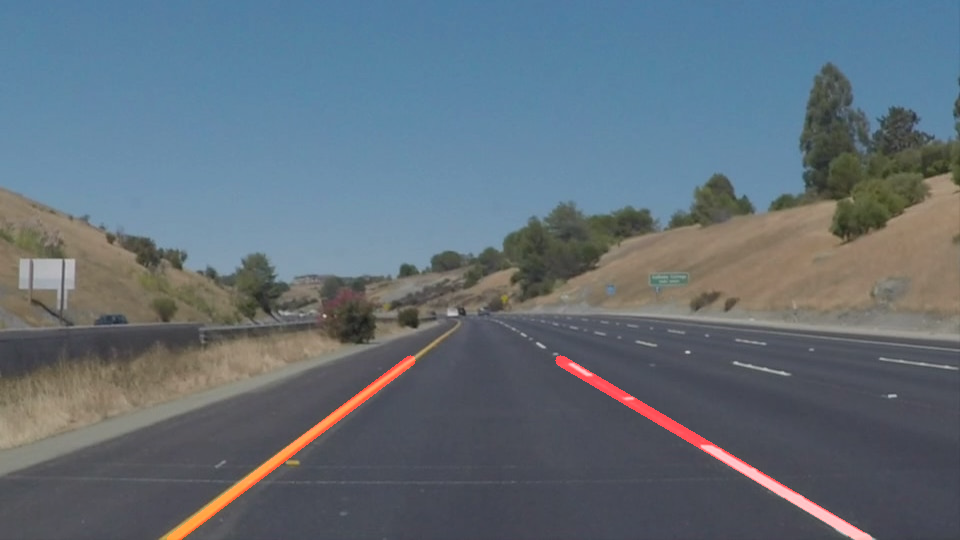

test_images_output/fit/solidWhiteCurve.jpg


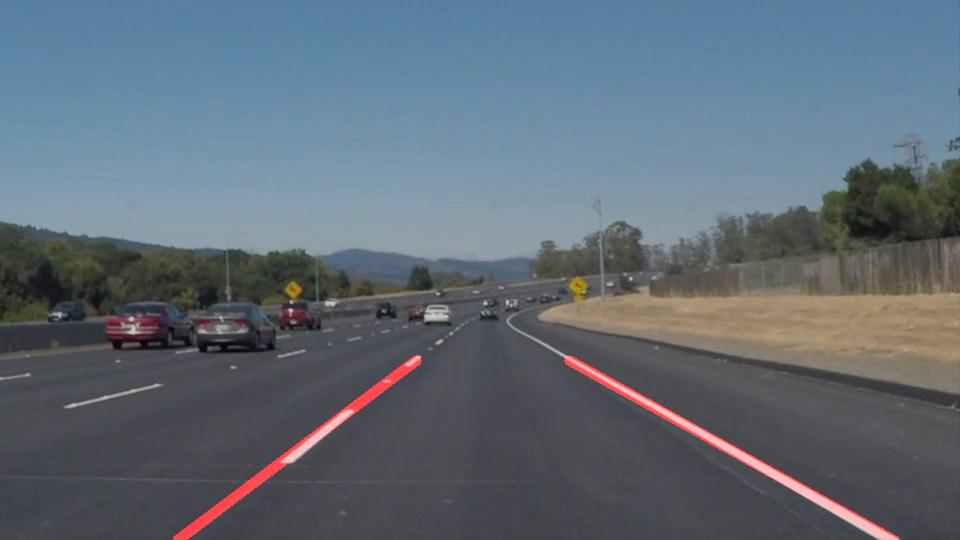

test_images_output/fit/whiteCarLaneSwitch.jpg


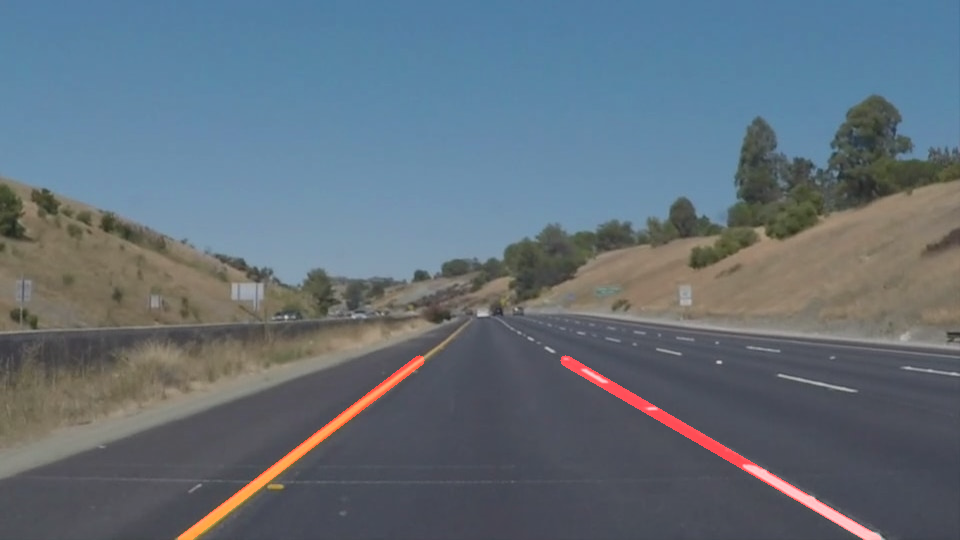

test_images_output/fit/solidWhiteRight.jpg


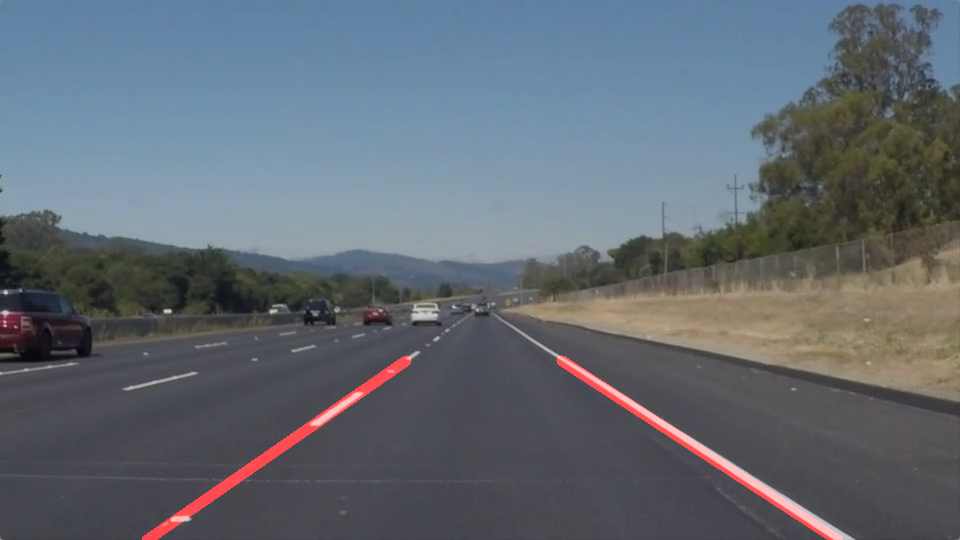

test_images_output/fit/solidYellowCurve.jpg


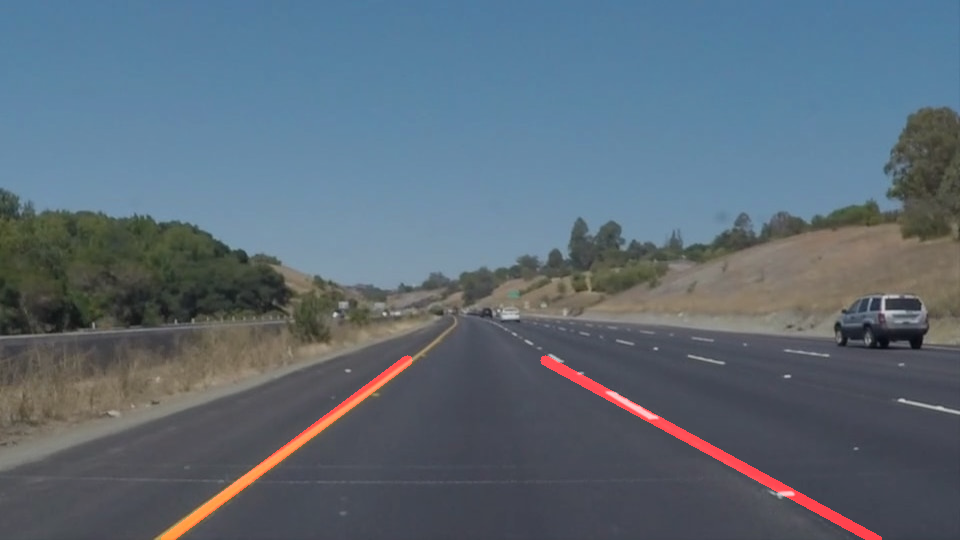

test_images_output/fit/solidYellowLeft.jpg


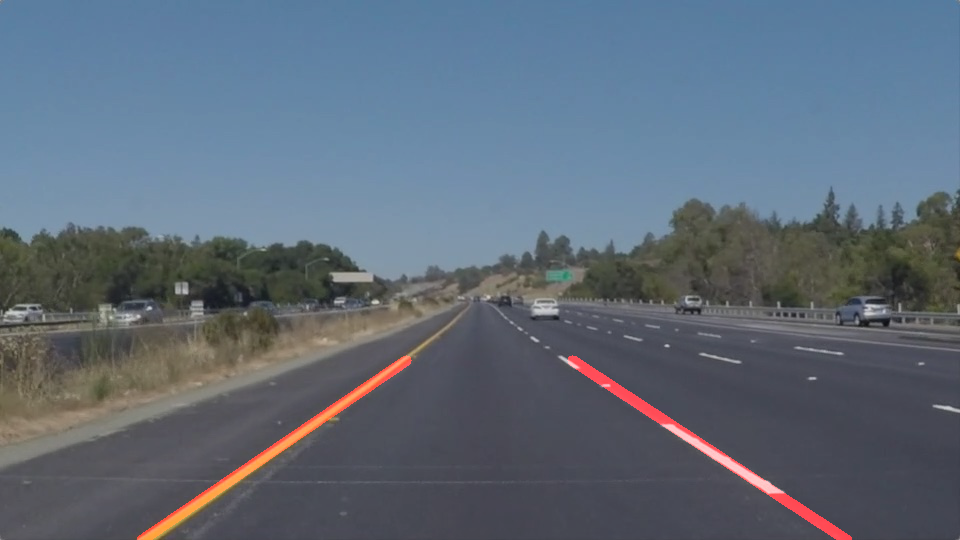

In [18]:
display_images("fit")

In [19]:
display_videos("fit")

test_videos_output/fit/challenge.mp4


test_videos_output/fit/solidWhiteRight.mp4


test_videos_output/fit/solidYellowLeft.mp4
